In [1]:
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras import backend as K

2023-12-07 15:23:17.198714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Test if gpu is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  2


2023-12-07 15:23:18.945499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 15:23:18.945679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 15:23:18.963227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'/device:GPU:0'

In [3]:
file_path = "./30_yr_stock_market_data.csv"
num_columns = len(np.genfromtxt(file_path, delimiter=',', max_rows=1))
load_string = lambda s: str(s)[2:-1]

value_converters = {i: lambda s: float(s or 0) for i in range(1,num_columns)}
value_converters[0] = load_string
name_converters = {i: load_string for i in range(num_columns)}

In [4]:
names = np.genfromtxt(
    file_path, 
    delimiter=',',
    converters = name_converters,
    max_rows=1
    ).item()

raw_data = np.genfromtxt(
    file_path, 
    delimiter=',', 
    skip_header=1,
    converters = value_converters,
    )

In [5]:
dates = [_data[0] for _data in raw_data]
dow_jones = [_data[1] for _data in raw_data]
sp500 = [_data[4] for _data in raw_data]
nasdaq = [_data[6] for _data in raw_data]
nyse = [_data[7] for _data in raw_data]
russell = [_data[8] for _data in raw_data]
cboe_volitility = [_data[9] for _data in raw_data]

data = [dates, dow_jones, sp500, nasdaq, nyse, russell, cboe_volitility]
selected_name = ["dates", "dow_jones", "sp500", "nasdaq", "nyse", "russell", "cboe_volitility"]

In [6]:
invalid_index = []
for i in range(len(dates)):
    if sp500[i] == 0:
        invalid_index.append(i)

invalid_index.reverse()
for ind in invalid_index:
    for j in range(len(data)):
        stock_data = data[j]
        stock_data.pop(ind)
            
for i in range(len(data)):
    print(selected_name[i])
    stock_data = data[i]
    print(f"Total data: {len(stock_data)}")
    print(f"# invalid data: {stock_data.count(0)}\n")


dates
Total data: 7554
# invalid data: 0

dow_jones
Total data: 7554
# invalid data: 0

sp500
Total data: 7554
# invalid data: 0

nasdaq
Total data: 7554
# invalid data: 0

nyse
Total data: 7554
# invalid data: 0

russell
Total data: 7554
# invalid data: 0

cboe_volitility
Total data: 7554
# invalid data: 0



In [7]:
def get_day_of_year(date_str: str):
    date_object = datetime.strptime(date_str, "%Y-%m-%d")
    return (date_object - datetime(date_object.year, 1, 1)).days + 1

def get_predicting_date(date_str: str, predict_period: int):
    date_object = datetime.strptime(date_str, "%Y-%m-%d")
    return date_object + timedelta(days=predict_period)


def get_date_diff(predict_date: str, latest_date: str):
    predict_date_object = datetime.strptime(predict_date, "%Y-%m-%d")
    latest_date_object = datetime.strptime(latest_date, "%Y-%m-%d")

    return (predict_date_object - latest_date_object).days - 10

def calculate_growth(base: int, target: int):
    return target/base

def calculate_acc(y_predicted, y_test):
    cnt = 0
    for i in range(len(y_predicted)):
        y_p = y_predicted[i]
        y_t = y_test[i]
        if y_p > 1 and y_t <= 1:
            cnt += 1
        if y_p <= 1 and y_t > 1:
            cnt += 1
    
    print(cnt, "/", len(y_test))
    return 100 - cnt/len(y_test)*100

print("get_day_of_year".upper(), f": {dates[0]}")
print(get_day_of_year(dates[0]))

print("calculate_growth".upper())
print(calculate_growth(58,102))

GET_DAY_OF_YEAR : 1993-11-18
322
CALCULATE_GROWTH
1.7586206896551724


In [8]:
"""
PROCESS DATA

X_data: proportion vs expected y_value
Y_data: proportion vs previous day y_value
"""
INPUT_SIZE = 90
PREDICT_PERIOD = 30
DATA_LENGTH = len(sp500)
X_data = []
Y_data = []


for i in range(DATA_LENGTH - INPUT_SIZE - PREDICT_PERIOD + 1):
    stack_data = []
    
    start_train_idx = i
    end_train_idx = start_train_idx + INPUT_SIZE - 1 
    predict_idx = end_train_idx + PREDICT_PERIOD
    
    
    y_based_value = sp500[end_train_idx]
    doy = get_day_of_year(dates[end_train_idx])
    
    for stock_data in data[1:]:
        interval_data = [doy] + [calculate_growth(x, y_based_value) for x in stock_data[start_train_idx : start_train_idx+INPUT_SIZE]]
        stack_data.append(interval_data)

    X_data.append(stack_data)
    
    y_growth = calculate_growth(sp500[start_train_idx], sp500[predict_idx])
    
    Y_data.append(y_growth)


X_data = np.array(X_data)
Y_data = np.array(Y_data)
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2)

In [9]:
print("Data dimension: ")
print("X dim:", len(X_data), len(X_data[0]), len(X_data[0][0]))
print("Y dim:", len(Y_data), "\n")
print("X begin: ", X_data[0][1][4])
print("X end: ", X_data[-1][1][4])
print("Y begin: ", Y_data[0])
print("Y end: ", Y_data[-1])


Data dimension: 
X dim: 7435 6 91
Y dim: 7435 

X begin:  0.997765874710921
X end:  1.0081215877757799
Y begin:  0.9522669317201929
Y end:  1.0799529969304786


In [10]:
# Default Model
K.clear_session()

EPOCH = 400
BATCH_SIZE = 50
VAL_SPLIT = 0.2

model = Sequential()
model.add(layers.Flatten(input_shape=(6, 91)))  
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='linear')) 

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
history = model.fit(
    x_train, 
    y_train, 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    validation_split=VAL_SPLIT
)

# Evaluate the model
test_loss = model.evaluate(x_test, y_test)
print(f"Mean Absoluted Error on Test Data: {test_loss}")

# Make predictions
predictions = model.predict(x_test)

Epoch 1/400


2023-12-07 15:23:19.961015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 15:23:19.961227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 15:23:19.961354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

96/96 [==============================] - 2s 3ms/step - loss: 0.4392 - val_loss: 0.2282
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1607 - val_loss: 0.0904
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1057 - val_loss: 0.1107
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.0841 - val_loss: 0.0727
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.0884 - val_loss: 0.0796
Epoch 6/400
96/96 [==============================] - 0s 2ms/step - loss: 0.0926 - val_loss: 0.0870
Epoch 7/400
96/96 [==============================] - 0s 2ms/step - loss: 0.0718 - val_loss: 0.1167
Epoch 8/400
96/96 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0592
Epoch 9/400
96/96 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0674
Epoch 10/400
96/96 [==============================] - 0s 2ms/step - loss: 0.0675 - val_loss: 0.0596
Epoch 11/400
96/96 [=

In [11]:
model.summary()
print(f"Mean Absoluted Error on Test Data: {test_loss}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 546)               0         
                                                                 
 dense (Dense)               (None, 256)               140032    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 32)                1

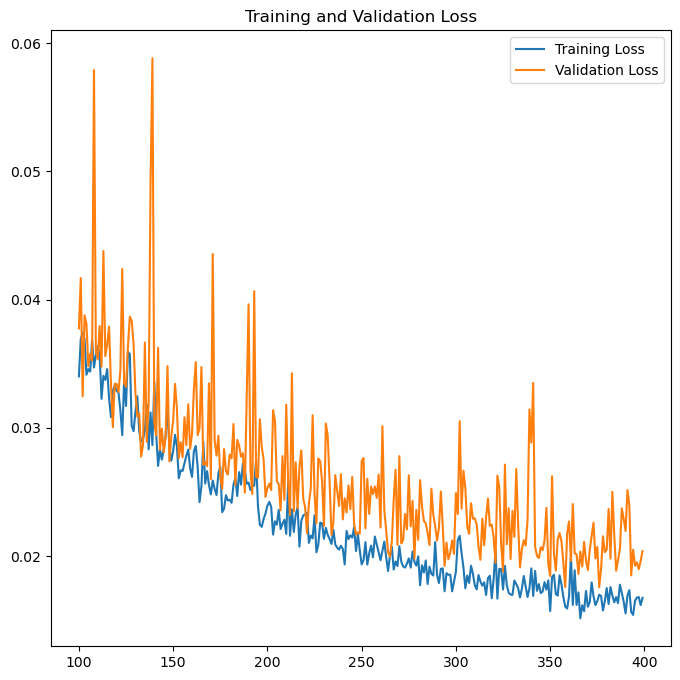

In [12]:
RANGE = 100
loss = history.history['loss'][RANGE:]
val_loss = history.history['val_loss'][RANGE:]

epochs_range = range(RANGE, EPOCH)
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
# loss

In [13]:
y_predicted = np.array([predict[0] for predict in predictions])
acc = calculate_acc(y_predicted, y_test)
print("Acc:", acc)

73 / 1487
Acc: 95.09078681909885


In [14]:
model.save("./models/pre_ft.h5")

In [15]:
pre_ft_model = keras.models.load_model("./models/pre_ft.h5")

FT_EPOCH = 130
FT_BATCH_SIZE = 16
FT_VAL_SPLIT = 0.2
FT_LEARNING_RATE = 0.0001

pre_ft_model.compile(optimizer=Adam(learning_rate=FT_LEARNING_RATE), loss='mean_absolute_error')

fine_tuned_history = pre_ft_model.fit(
    x_train, 
    y_train, 
    epochs=FT_EPOCH, 
    batch_size=FT_BATCH_SIZE, 
    validation_split=FT_VAL_SPLIT
)

# Evaluate the model
fine_tuned_test_loss = pre_ft_model.evaluate(x_test, y_test)
print(f"Fine Tuned Mean Absoluted Error on Test Data: {fine_tuned_test_loss}")

# Make predictions
fine_tuned_predictions = pre_ft_model.predict(x_test)

Epoch 1/130
298/298 [==============================] - 2s 2ms/step - loss: 0.0120 - val_loss: 0.0153
Epoch 2/130
298/298 [==============================] - 1s 2ms/step - loss: 0.0110 - val_loss: 0.0155
Epoch 3/130
298/298 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0156
Epoch 4/130
298/298 [==============================] - 1s 2ms/step - loss: 0.0105 - val_loss: 0.0148
Epoch 5/130
298/298 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0147
Epoch 6/130
298/298 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0154
Epoch 7/130
298/298 [==============================] - 1s 2ms/step - loss: 0.0103 - val_loss: 0.0148
Epoch 8/130
298/298 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0150
Epoch 9/130
298/298 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0146
Epoch 10/130
298/298 [==============================] - 1s 2ms/step - loss: 0.0102 - val_lo

In [16]:
pre_ft_model.summary()
print(f"Fine Tuned Mean Absoluted Error on Test Data: {fine_tuned_test_loss}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 546)               0         
                                                                 
 dense (Dense)               (None, 256)               140032    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 32)                1

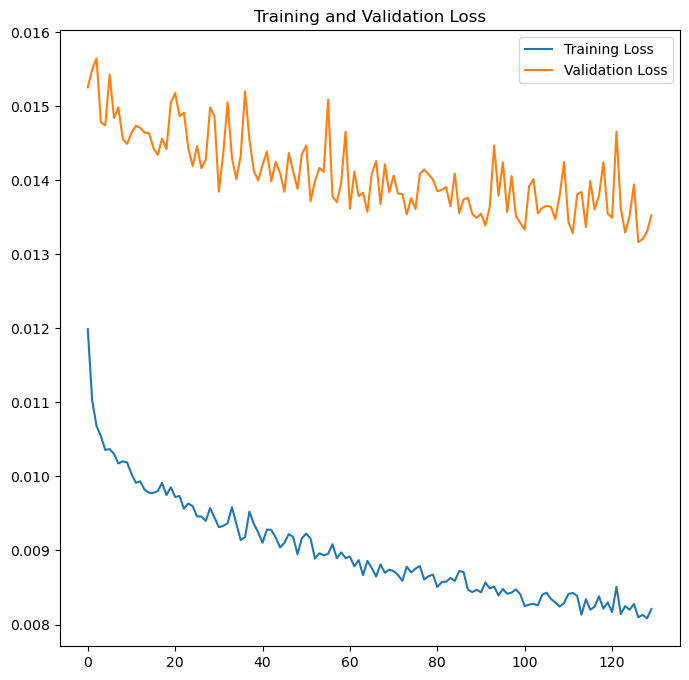

In [17]:
FT_RANGE = 0
loss = fine_tuned_history.history['loss'][FT_RANGE:]
val_loss = fine_tuned_history.history['val_loss'][FT_RANGE:]

epochs_range = range(FT_RANGE, FT_EPOCH)
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# pre_ft_model.save("./models/prod_ft.h5")

In [19]:
ft_y_predicted = np.array([predict[0] for predict in fine_tuned_predictions])
ft_acc = calculate_acc(ft_y_predicted, y_test)
print("Acc:", ft_acc)

51 / 1487
Acc: 96.57027572293208


In [20]:
print("Loss:", test_loss, "->", fine_tuned_test_loss)
print("Acc:", acc, "->", ft_acc)

Loss: 0.0194373931735754 -> 0.013070126064121723
Acc: 95.09078681909885 -> 96.57027572293208


In [21]:
# FT_RANGE = 0
# _y_test = y_test[FT_RANGE:]
# _y_predicted = fine_tuned_predictions[FT_RANGE:]

# data_range = range(FT_RANGE, len(y_test))
# plt.figure(figsize=(100, 10))

# plt.plot(data_range, _y_test, label='Y TEST')
# plt.plot(data_range, _y_predicted, label='Y PREDICTED')
# plt.axhline(y=1, color='r', linestyle='-', label='y=1')
# plt.legend(loc='upper right')
# plt.title('Test and Predicted')
# plt.savefig('output_plot.png')

# plt.show()